<a href="https://colab.research.google.com/github/QuangHPV/sc1015-project/blob/main/Multilayer_Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mulilayer Perceptron

Multilayer perceptron is a deep learning method for classification. In this notebook, we only use 'KNN Imputations' method, as MLP is a deep learning method, and it works well when are fed a huge amount of data. Our KNN Imputation method fill in missing values, and also cluster some data and change it, so we have much longer dataset compared to manually cleaned method

# Load the dataset

In [1]:
!git clone https://github.com/QuangHPV/sc1015-project.git

Cloning into 'sc1015-project'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 46 (delta 7), reused 24 (delta 2), pack-reused 0
Receiving objects: 100% (46/46), 11.41 MiB | 12.76 MiB/s, done.
Resolving deltas: 100% (7/7), done.


# Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

In [3]:
df = pd.read_csv("/content/sc1015-project/data/weatherAUS_knn_impuation.csv")
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,2,13.4,22.9,0.6,3.84,7.76,13,44.0,13,...,71.0,22.0,1007.7,1007.1,8.0,7.0,16.9,21.8,0,0
1,2008-12-02,2,7.4,25.1,0.0,5.04,9.82,14,44.0,6,...,44.0,25.0,1010.6,1007.8,7.0,7.0,17.2,24.3,0,0
2,2008-12-03,2,12.9,25.7,0.0,4.52,9.50,15,46.0,13,...,38.0,30.0,1007.6,1008.7,7.0,2.0,21.0,23.2,0,0
3,2008-12-04,2,9.2,28.0,0.0,3.52,8.54,4,24.0,9,...,45.0,16.0,1017.6,1012.8,7.0,7.0,18.1,26.5,0,0
4,2008-12-05,2,17.5,32.3,1.0,4.44,10.46,13,41.0,1,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0


# Spliting trainning, testing

In [4]:
X = df.drop(['Date', 'RainTomorrow'], axis=1)
y = df['RainTomorrow']
print('Len of X', len(X))
print('Len of y', len(y))

Len of X 145460
Len of y 145460


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Converting to numpy

X_train_scaled = np.asarray(X_train_scaled)
X_test_scaled = np.asarray(X_test_scaled)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

# Pytorch Dataset:
This is a pytorch dataset for using pytorch library.
What we will do in this class:
- Normalize the data
- Change it to Pytorch tensor

In [6]:
class WeatherAUSDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # print(idx)
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

In [7]:
train_data = WeatherAUSDataset(X_train_scaled, y_train)
test_data = WeatherAUSDataset(X_test_scaled, y_test)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

In [8]:
next(iter(train_loader))

[tensor([[ 1.7392e-02,  6.0914e-01,  1.0548e+00, -2.8022e-01,  1.1458e-01,
           5.4605e-01,  1.0452e+00, -4.0103e-01, -8.8656e-01,  2.6403e-01,
          -1.3999e-01,  5.4370e-01, -4.9491e-01, -6.7890e-01,  2.4362e-01,
          -5.3874e-01,  6.0721e-01,  6.0790e-01,  1.1677e+00,  1.0234e+00,
          -5.2953e-01],
         [-1.5292e+00, -8.3031e-01, -6.6408e-01, -2.5657e-01, -4.1898e-01,
           7.6198e-01,  1.9330e-01, -5.0611e-01,  4.4160e-01,  7.0466e-01,
           3.3281e-01, -1.1013e+00, -6.3238e-01, -5.6219e-01,  7.7777e-01,
           1.0147e+00,  6.0721e-01,  6.0790e-01, -9.2185e-01, -6.9688e-01,
          -5.2953e-01],
         [ 1.0016e+00, -7.9895e-01, -8.3315e-01, -2.8022e-01, -4.0100e-01,
           6.6966e-02,  1.0452e+00,  2.4444e-01, -1.1223e-03,  1.3656e+00,
          -1.1748e-01,  1.2976e+00, -1.0554e+00, -1.1944e+00,  7.7248e-02,
          -1.5050e-02, -9.4120e-01, -1.0408e+00, -7.3665e-01, -6.8235e-01,
          -5.2953e-01],
         [-1.5292e+00,  1.23

# Model

We also provide Adam optimizer, and we defind our loss function is Binary Cross Entropy Loss, as we work on binary classification problem.

In [18]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, hidden_dims// 2)
        self.linear3 = nn.Linear(hidden_dims// 2, hidden_dims//4)
        self.output = nn.Linear(hidden_dims//4, output_dims)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        out = self.output(x)
        out = self.sigmoid(out)
        return out.squeeze(1)

In [19]:
model = MLP(input_dims=21, hidden_dims=64, output_dims=1).to(device)

In [20]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Training

In [22]:
from sklearn.metrics import accuracy_score

num_epochs = 100
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_targets = []
    train_predictions = []

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        predicted = outputs.round()
        train_predictions.extend(predicted.tolist())
        train_targets.extend(y.tolist())
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_acc = accuracy_score(train_targets, train_predictions)
    train_accs.append(train_acc)

    model.eval()
    test_loss = 0.0
    test_targets = []
    test_predictions = []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            predicted = outputs.round()
            test_predictions.extend(predicted.tolist())
            test_targets.extend(y.tolist())
            loss = criterion(outputs, y)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_acc = accuracy_score(test_targets, test_predictions)
    test_accs.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train_Loss: {train_loss:.4f}, Train_Accuracy: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Epoch 1/100, Train_Loss: 0.3469, Train_Accuracy: 0.8505, Test Loss: 0.3515, Test Accuracy: 0.8466
Epoch 2/100, Train_Loss: 0.3443, Train_Accuracy: 0.8519, Test Loss: 0.3484, Test Accuracy: 0.8476
Epoch 3/100, Train_Loss: 0.3423, Train_Accuracy: 0.8530, Test Loss: 0.3475, Test Accuracy: 0.8485
Epoch 4/100, Train_Loss: 0.3405, Train_Accuracy: 0.8541, Test Loss: 0.3477, Test Accuracy: 0.8480
Epoch 5/100, Train_Loss: 0.3390, Train_Accuracy: 0.8542, Test Loss: 0.3478, Test Accuracy: 0.8485
Epoch 6/100, Train_Loss: 0.3376, Train_Accuracy: 0.8549, Test Loss: 0.3472, Test Accuracy: 0.8482
Epoch 7/100, Train_Loss: 0.3365, Train_Accuracy: 0.8557, Test Loss: 0.3445, Test Accuracy: 0.8496
Epoch 8/100, Train_Loss: 0.3356, Train_Accuracy: 0.8560, Test Loss: 0.3426, Test Accuracy: 0.8499
Epoch 9/100, Train_Loss: 0.3342, Train_Accuracy: 0.8565, Test Loss: 0.3436, Test Accuracy: 0.8491
Epoch 10/100, Train_Loss: 0.3335, Train_Accuracy: 0.8567, Test Loss: 0.3450, Test Accuracy: 0.8491
Epoch 11/100, Train

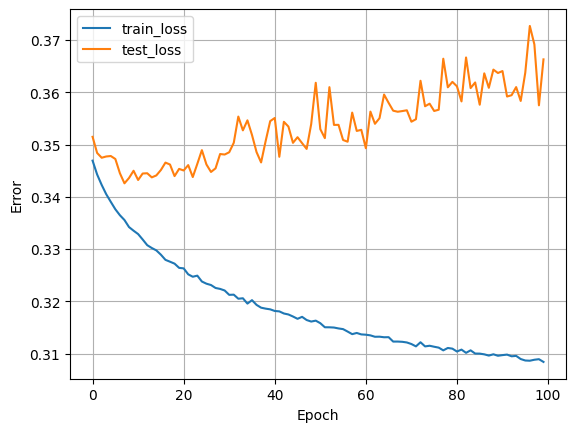

In [25]:
plt.plot(train_losses, label='train_loss')
plt.plot(test_losses, label='test_loss')
# plt.ylim([0, 40])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

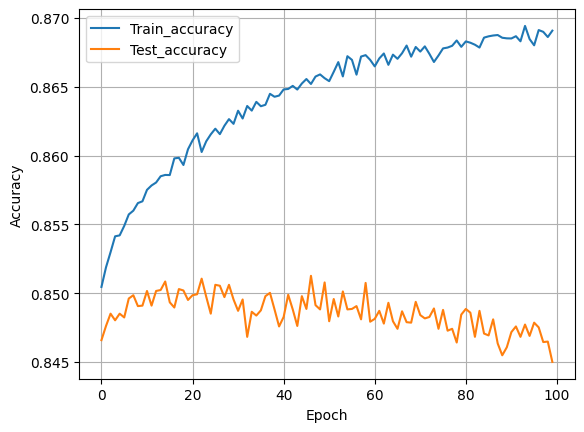

In [26]:
plt.plot(train_accs, label='Train_accuracy')
plt.plot(test_accs, label='Test_accuracy')
# plt.ylim([0, 40])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

From observing, the model is a bit overfitting. However, the best accuracy score for test_accuracy is `0.8652`, which is better than the previous models we did.